# Cyclical Learning using Fashion_MNIST dataset
## References:
1. Leslie Smith, "Cyclical Learning Rates for Training Neural Networks", arXiv: 1506.01186
2. https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use("Agg")

import os, sys
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.datasets import fashion_mnist
#from keras.datasets import cifar10

from utils.learningratefinder import LearningRateFinder
from utils.clr_callback import CyclicLR
from model.minigooglenet import MiniGoogLeNet

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Define hyper-parameters

In [2]:
# initialize the list of class label names
CLASSES = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]

# define hyper-parameters
MIN_LR = 1e-5
MAX_LR = 1e-2
BATCH_SIZE = 64
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 48
lr_find = 1

# define plot path
LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot2.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot2.png"])
CLR_PLOT_PATH = os.path.sep.join(["output", "clr_plot2.png"])

# Load data

In [3]:
print("[INFO] loading Fashion MNIST data...")
((X_train, Y_train), (X_test, Y_test)) = fashion_mnist.load_data()

# Fashion MNIST images are 28x28, reshape to 32x32
X_train = np.array([cv2.resize(x, (32, 32)) for x in X_train])
X_test = np.array([cv2.resize(x, (32, 32)) for x in X_test])

# normalization
X_train = X_train.astype("float") / 255.0
X_test = X_test.astype("float") / 255.0

# reshape
X_train = X_train.reshape((X_train.shape[0], 32, 32, 1))
X_test = X_test.reshape((X_test.shape[0], 32, 32, 1))

"""One can also try cifar10 dataset
print("[INFO] loading CIFAR-10 data...")
((X_train, Y_train), (X_test, Y_test)) = cifar10.load_data()
X_train = X_train.astype("float")
X_test = X_test.astype("float")

# apply mean subtraction to the data
mean = np.mean(X_train, axis=0)
X_train -= mean
X_test -= mean
"""

# One-hot encoding
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)

[INFO] loading Fashion MNIST data...


In [4]:
# construct the image generator for data augmentation
gen_aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode="nearest")

# Model construction

In [5]:
# initialize a model
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 96)   960         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 96)   384         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 96)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
# initialize the optimizer
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


# Find learning rate

[INFO] finding learning rate...
Epoch 1/3
938/938 [==============================] - 37s 39ms/step - loss: 2.5533 - acc: 0.1046
Epoch 2/3
938/938 [==============================] - 34s 36ms/step - loss: 2.0813 - acc: 0.2594
Epoch 3/3
938/938 [==============================] - 34s 36ms/step - loss: 1.0438 - acc: 0.6524
[INFO] learning rate finder complete
[INFO] examine plot and adjust learning rates before training


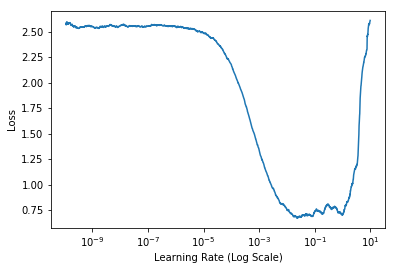

In [7]:
if lr_find > 0:
# initialize the learning rate finder (from 1e-10 to 1e+1)
    print("[INFO] finding learning rate...")
    lrf = LearningRateFinder(model)
    lrf.find(gen_aug.flow(X_train, Y_train, batch_size=BATCH_SIZE), 1e-10, 1e+1,
    stepsPerEpoch=np.ceil((len(X_train) / float(BATCH_SIZE))), batchSize=BATCH_SIZE)

    # plot the loss and save the resulting plot to disk
    lrf.plot_loss()
    plt.savefig(LRFIND_PLOT_PATH)
    
    print("[INFO] learning rate finder complete")
    print("[INFO] examine plot and adjust learning rates before training")
    #exit(0)

# Cyclical training

In [8]:
# otherwise, we have already defined a learning rate space to train
# over, so compute the step size and initialize the cyclic learning
# rate method
stepSize = STEP_SIZE * (X_train.shape[0] // BATCH_SIZE)
clr = CyclicLR(mode=CLR_METHOD, base_lr=MIN_LR, max_lr=MAX_LR, step_size=stepSize)

# train the network
print("[INFO] training network...")
H = model.fit_generator(gen_aug.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, Y_test),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[clr],
    verbose=1)

# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(X_test, batch_size=BATCH_SIZE)
print(classification_report(Y_test.argmax(axis=1),
predictions.argmax(axis=1), target_names=CLASSES))

[INFO] training network...
Epoch 1/48
937/937 [==============================] - 35s 37ms/step - loss: 11.9532 - acc: 0.2060 - val_loss: 9.5905 - val_acc: 0.1000
Epoch 2/48
937/937 [==============================] - 34s 36ms/step - loss: 4.3061 - acc: 0.6220 - val_loss: 3.7441 - val_acc: 0.6223
Epoch 3/48
937/937 [==============================] - 34s 36ms/step - loss: 2.4137 - acc: 0.7578 - val_loss: 1.9378 - val_acc: 0.7924
Epoch 4/48
937/937 [==============================] - 34s 37ms/step - loss: 1.9025 - acc: 0.8056 - val_loss: 1.7954 - val_acc: 0.8379
Epoch 5/48
937/937 [==============================] - 34s 36ms/step - loss: 1.8513 - acc: 0.8207 - val_loss: 1.8728 - val_acc: 0.8158
Epoch 6/48
937/937 [==============================] - 34s 37ms/step - loss: 1.8281 - acc: 0.8278 - val_loss: 1.8572 - val_acc: 0.8179
Epoch 7/48
937/937 [==============================] - 34s 36ms/step - loss: 1.8054 - acc: 0.8364 - val_loss: 2.0707 - val_acc: 0.7344
Epoch 8/48
937/937 [==============

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Plot results

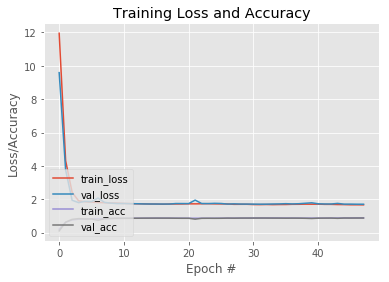

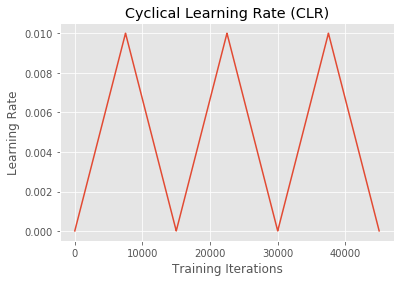

In [9]:
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)

# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.savefig(CLR_PLOT_PATH)